In [1]:
!pip install tensorflow_federated
!pip install attention

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from attention import Attention
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import collections
import random
import time
import math
import os

In [3]:
def create_fl_clients(data, target, no_of_clients):
    '''
    data - pandas dataframe
    clients - number of FL clients to split the data
    '''
    datasets = []
    for cid in range(no_of_clients):
        #creating a partition value as per the number of FL clients
        partition_size = math.floor(len(data) / no_of_clients)
        #creating indexes to subset the dataframe
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        #subsetting dataframe
        train_batch = data[idx_from:idx_to]
        target_batch = target[idx_from:idx_to]

        dataset = tf.data.Dataset.from_tensor_slices((train_batch, target_batch)).batch(1)
        datasets.append(dataset)

    return datasets

In [4]:
def model_fn():
    model = create_model_fn()
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
    input_spec = dataset.element_spec
    return tff.learning.models.from_keras_model(
      model,
      input_spec = input_spec,
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [5]:
import time
import datetime

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def train(trainer, train_data, val_data, num_rounds, no_of_clients, fit_on):
    train_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR)

    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    #we want to set the federated learning params to be set to default
    state = trainer.initialize()
    #create model for evaluation
    eval = tff.learning.build_federated_evaluation(model_fn)
    return_state = None
    best_loss = None
    #for plotting we declare arrays
    train_acc = []
    train_mse = []
    train_loss = []
    eval_acc = []
    eval_mse = []
    eval_loss = []

    # test_acc = []
    # test_loss = []
    for n in range(num_rounds):
        t1 = time.time()
        print("Training...")
        #passing the new state with randomly chosen training dataset
        result = trainer.next(state, train_data)
        #setting new state for trained parameters
        state = result.state
        #declaring taining metrics
        train_metrics = result.metrics['client_work']['train']
        print("Evaluating...")
        #using learning algorithm we pass the currrent state of round for evaluation
        eval_metrics = eval(trainer.get_model_weights(state), [val_data])
        eval_metrics = eval_metrics['eval']
        print("Done...")
        t2 = time.time()
        print('Round:{a} Train - RMSE:{m:.4f} MAE:{x:.4f}, Loss:{t:.4f} | Eval - RMSE:{b:.4f} MAE:{d:.4f}, Loss:{c:.4f} | Time - {f:.2f}'.format(
              a=n+1,
              m=train_metrics['root_mean_squared_error'],
              x=train_metrics['mean_absolute_error'],
              t=train_metrics['loss'],
              b=eval_metrics['root_mean_squared_error'],
              d=eval_metrics['mean_absolute_error'],
              c=eval_metrics['loss'],
              # d=test_metrics['root_mean_squared_error'],
              # e=test_metrics['loss']
              f=t2-t1
        ))

        #early stopping
        if(best_loss != None and eval_metrics['loss'] >= best_loss):
          print("LOSS DID NOT IMPROVE...")
        else:
          print("Loss improved!")
          return_state = result.state
          best_loss = eval_metrics['loss']
          print("Saving model state...")

        #assigning metrics for plotting purposes
        train_acc.append(train_metrics['root_mean_squared_error'])
        train_mse.append(train_metrics['mean_absolute_error'])
        train_loss.append(train_metrics['loss'])

        eval_acc.append(eval_metrics['root_mean_squared_error'])
        eval_mse.append(eval_metrics['mean_absolute_error'])
        eval_loss.append(eval_metrics['loss'])

        with train_summary_writer.as_default():
          tf.summary.scalar("training/rmse", train_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("training/mse", train_metrics['mean_absolute_error'], step=n+1)

          tf.summary.scalar("validation/rmse", eval_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("validation/mse", eval_metrics['mean_absolute_error'], step=n+1)

        #using learning algorithm we pass the currrent state of round for testing
        # test_metrics = eval(trainer.get_model_weights(state), [test_client_data])
        # test_metrics = test_metrics['eval']




    return return_state, train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss

In [6]:
import matplotlib
def plot(train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss):
  plt.figure(figsize=(16, 6))
  plt.plot(train_acc, label="Training RMSE")
  plt.plot(eval_acc, label="Evaluation RMSE")
  plt.title("RMSE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("RMSE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

  plt.figure(figsize=(16, 6))
  plt.plot(train_mse, label="Training MAE")
  plt.plot(eval_mse, label="Evaluation MAE")
  plt.title("MAE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("MAE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

In [7]:
def normalize(data):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std
    # scaler = MinMaxScaler(feature_range=(0,1))
    # transformed = scaler.fit_transform(data)
    # return transformed, scaler

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [11]:
def create_model_fn():
  input = keras.layers.Input(shape=(past, input_size))
  layer = keras.layers.Conv1D(filters=15, kernel_size=2, padding="same", activation="relu")(input)
  layer = tf.keras.layers.MaxPooling1D(pool_size=2)(layer)
  layer = keras.layers.Conv1D(filters=12, kernel_size=2, padding="same", activation="relu")(layer)
  layer = tf.keras.layers.LSTM(32, return_sequences=True)(layer)
  layer = Attention(units=10)(layer)
  output = keras.layers.Dense(future)(layer)

  model = keras.Model(inputs=input, outputs=output)
  return model

In [13]:
def optimizers(SERVER_LR, CLIENT_LR):
  server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
  client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

  return server_optimizer_fn, client_optimizer_fn

In [50]:
s1 = pd.read_csv('../data/s1.csv')
#dropping uncessary columns
s1 = s1.drop(['Unnamed: 0'], axis=1)

split_fraction = 1.0
train_split = int(split_fraction * int(s1.shape[0]))
step = 1

past = 6 #past 7 days (7*24=168 hours)
future = 1 #using past 168 steps predict next 24 steps (24 hours)

In [51]:
s1 = s1.rename(columns={'pm10(ug/m3)': 'pm10', 'pm2.5(ug/m3)': 'pm2.5'})

In [53]:
features = s1[["temp", "wetb", "dewpt", "vappr", "pm10"]]
features.index = s1["datetime"]
feature_columns = features.columns
#print(features.head())

targets = s1[["pm2.5"]]
targets_columns = targets.columns

features = normalize(features.values)
#targets = scaler.transform(targets.values)

features_df = pd.DataFrame(features, columns = feature_columns)
#targets = pd.DataFrame(targets, columns = targets_columns)

input_size = len(features_df.columns)

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)

In [54]:
val_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

In [55]:
model_test2 = create_model_fn()
# trained_model = trainer.get_model_weights(state2)
# trained_model.assign_weights_to(model_test2)
model_test2.load_weights('./checkpoints/public_data/past_6')
predictions = []
true_val = []
index = 0
for x, y in val_data:
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  # with test_summary_writer.as_default():
  #   tf.summary.scalar("predictions/true" ,true, step=index+1)
  #   tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  # index += 1

  predictions.append(pred)
  true_val.append(true)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step


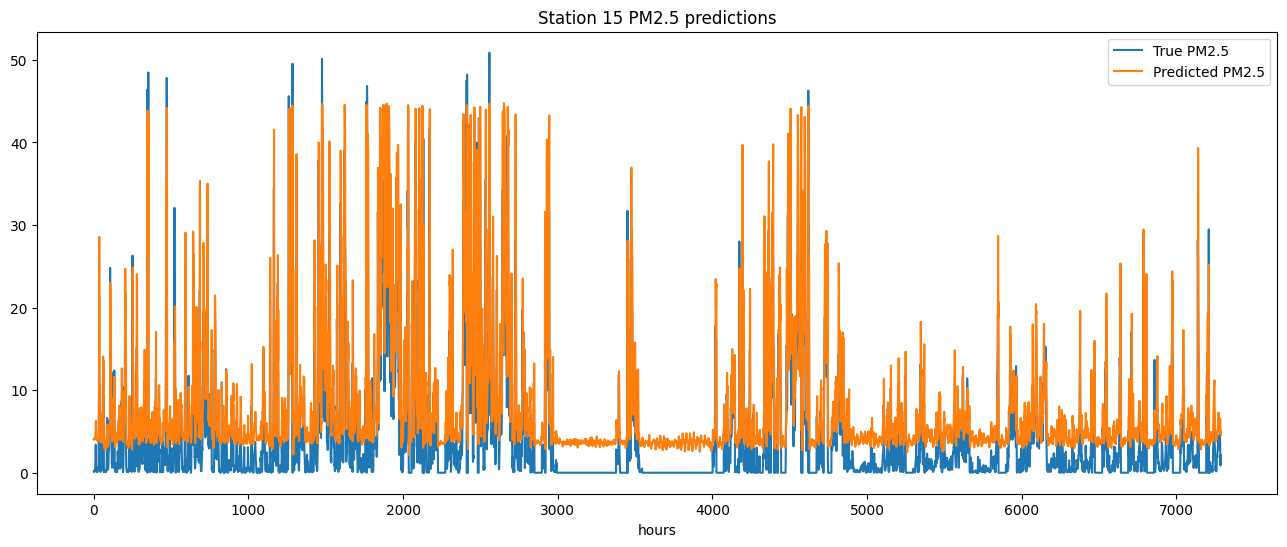

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("Station 15 PM2.5 predictions")
plt.xlabel("hours")
plt.legend()
plt.show()

In [56]:
s1_predictions = pd.DataFrame({ "predictions": predictions })
s1["pm2.5_predictions"] = s1_predictions["predictions"]

In [59]:
s1.to_csv("../data/s1_predictions.csv")

In [39]:
predictions_tensor = tf.constant(predictions, dtype=tf.float32)
true_values_tensor = tf.constant(true_val, dtype=tf.float32)

# Compute RMSE
rmse = tf.sqrt(tf.reduce_mean(tf.square(predictions_tensor - true_values_tensor)))

# Compute MAE
mae = tf.reduce_mean(tf.abs(predictions_tensor - true_values_tensor))

In [40]:
print(rmse)
print(mae)

tf.Tensor(5.6339617, shape=(), dtype=float32)
tf.Tensor(4.2880254, shape=(), dtype=float32)


In [60]:
s2 = pd.read_csv('../data/s2.csv')
#dropping uncessary columns
s2 = s2.drop(['Unnamed: 0'], axis=1)

split_fraction = 1.0
train_split = int(split_fraction * int(s2.shape[0]))
step = 1

past = 6 #past 7 days (7*24=168 hours)
future = 1 #using past 168 steps predict next 24 steps (24 hours)

In [61]:
s2 = s2.rename(columns={'pm10(ug/m3)': 'pm10', 'pm2.5(ug/m3)': 'pm2.5'})

In [62]:
features = s2[["temp", "wetb", "dewpt", "vappr", "pm10"]]
features.index = s2["datetime"]
feature_columns = features.columns
#print(features.head())

targets = s2[["pm2.5"]]
targets_columns = targets.columns

features = normalize(features.values)
#targets = scaler.transform(targets.values)

features_df = pd.DataFrame(features, columns = feature_columns)
#targets = pd.DataFrame(targets, columns = targets_columns)

input_size = len(features_df.columns)

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)

In [63]:
val_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

In [64]:
predictions = []
true_val = []
index = 0
for x, y in val_data:
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  # with test_summary_writer.as_default():
  #   tf.summary.scalar("predictions/true" ,true, step=index+1)
  #   tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  # index += 1

  predictions.append(pred)
  true_val.append(true)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step


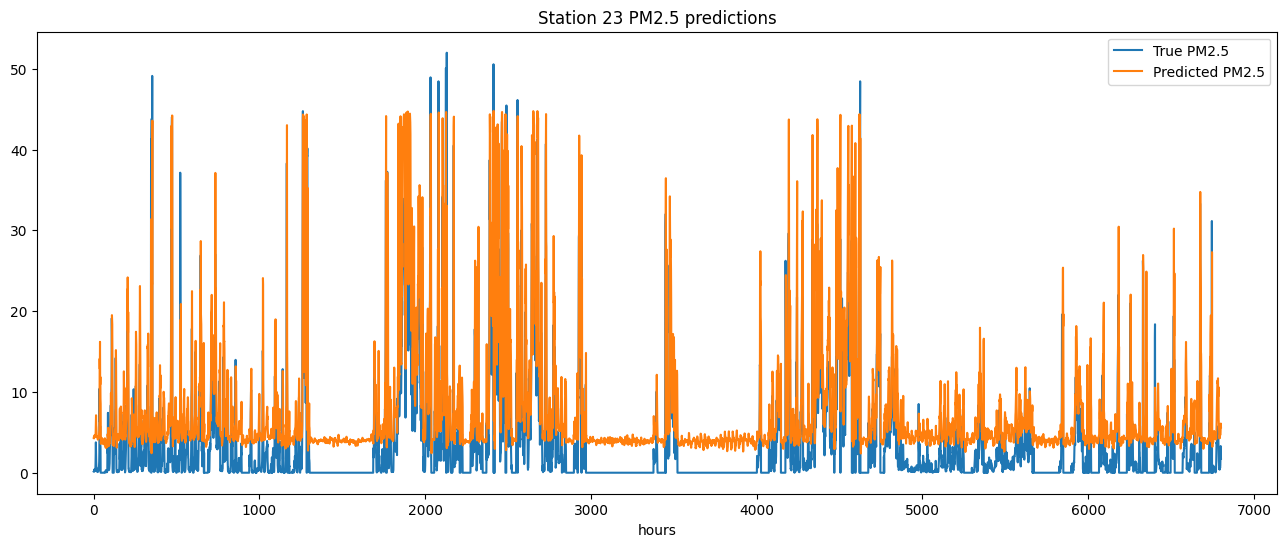

In [47]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("Station 23 PM2.5 predictions")
plt.xlabel("hours")
plt.legend()
plt.show()

In [48]:
predictions_tensor = tf.constant(predictions, dtype=tf.float32)
true_values_tensor = tf.constant(true_val, dtype=tf.float32)

# Compute RMSE
rmse = tf.sqrt(tf.reduce_mean(tf.square(predictions_tensor - true_values_tensor)))

# Compute MAE
mae = tf.reduce_mean(tf.abs(predictions_tensor - true_values_tensor))

In [49]:
print(rmse)
print(mae)

tf.Tensor(5.9128737, shape=(), dtype=float32)
tf.Tensor(4.5753417, shape=(), dtype=float32)


In [65]:
s2_predictions = pd.DataFrame({ "predictions": predictions })
s2["pm2.5_predictions"] = s2_predictions["predictions"]

In [67]:
s2.to_csv("../data/s2_predictions.csv")